# Spindles detection on specific sleep stages

This notebook demonstrates how to apply **spindles detection on specific sleep stages** by providing an hypnogram (= sleep stage) to YASA.

Please make sure to install the latest version of YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`


## 1. Loading the EEG data and the hypnogram

We first load a full-night 3-channels dataset (Cz, Fz, Pz) sampled at 100 Hz. The data is in compressed NumPy format (*.npz*).

In [1]:
import yasa
import numpy as np
import pandas as pd
import seaborn as sns

# Load data
f = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz')
data, ch_names = f['data'], f['chan']
sf = 100.
times = np.arange(data.size) / sf

print(data.shape, ch_names)
print(np.round(data[:, 0:5], 3))

/Users/raphael/.pyenv/versions/3.8.3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


(3, 2161058) ['Cz' 'Fz' 'Pz']
[[15.797 22.307 39.922 25.657 27.094]
 [16.896 26.385 40.966 21.833 24.456]
 [ 5.899 14.297 36.592 26.094 23.395]]


/Users/raphael/.pyenv/versions/3.8.3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Next, we load the sleep staging vector (a.k.a hypnogram), which is a simple text file in which each value typically represents 30 seconds of data. Sleep stages are encoded as integer (*0: Wake, 1: N1 sleep, 2: N2 sleep, 3: N3 sleep, 4: REM sleep*). In the code below, we load our 30-sec hypnogram and upsample it to match the sampling frequency and length of data, using YASA's built-in [hypno_upsample_to_data](https://raphaelvallat.com/yasa/build/html/generated/yasa.hypno_upsample_to_data.html#yasa.hypno_upsample_to_data) function. Please refer to [08_bandpower.ipynb](08_bandpower.ipynb) for more details on how to manipulate hypnogram in YASA.

In [2]:
hypno_30s = np.loadtxt('data_full_6hrs_100Hz_hypno_30s.txt')
hypno = yasa.hypno_upsample_to_data(hypno=hypno_30s, sf_hypno=(1/30), data=data, sf_data=sf)
print(hypno.shape, 'Unique values =', np.unique(hypno))

11-Aug-21 12:16:23 | WARNING | Hypnogram is SHORTER than data by 10.58 seconds. Padding hypnogram with last value to match data.size.


(2161058,) Unique values = [0. 1. 2. 3. 4.]


To have a quick overview of our data, we can use [yasa.plot_spectrogram](https://raphaelvallat.com/yasa/build/html/generated/yasa.plot_spectrogram.html) function. Please check out [10_spectrogram.ipynb](10_spectrogram.ipynb) for a walkthrough of this function.

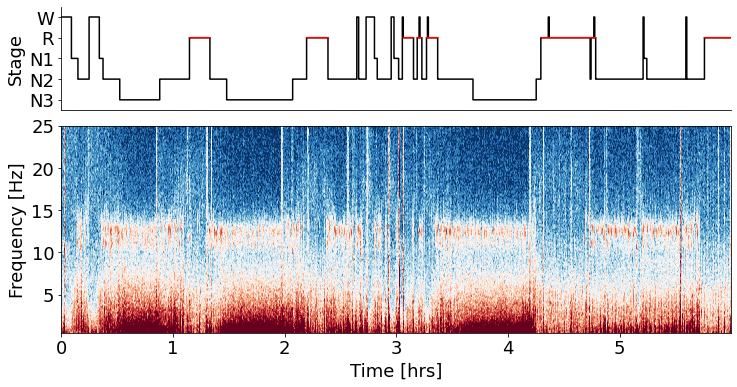

In [3]:
# We use data[0, :] to select only the first channel, which in this case is Cz
fig = yasa.plot_spectrogram(data[0, :], sf, hypno)

The top panel shows the full-night hypnogram, and the bottom panel show the time-frequency representation of the full-night recording, with warmer colors indicating greater power in the frequency range defined on the left y-axis. Notice how we can definitely see some spindles-related activity around 12-15 Hz during N2 and N3 sleep.

## 2. Apply the sleep spindles detection

To apply the multi-channel detection, we use the [yasa.spindles_detect](https://raphaelvallat.com/yasa/build/html/generated/yasa.spindles_detect.html) function. We also pass the hypnogram to restrain the detection to specific sleep stages, which are defined as integers in the ``include`` argument. Below, we're limiting the detection to NREM sleep, i.e. N1 (=1), N2 (=2) and N3 (=3) sleep.

In [4]:
sp = yasa.spindles_detect(data, sf, ch_names=ch_names, hypno=hypno, include=(1, 2, 3))

# Display the full detection dataframe
sp.summary().round(3)

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage,Channel,IdxChannel
0,522.55,522.78,523.79,1.24,45.569,10.891,2.133,0.470,13.080,16.0,0.184,1,Cz,0
1,585.54,586.09,586.38,0.84,59.683,13.335,2.257,0.476,12.959,10.0,0.647,2,Cz,0
2,598.08,598.62,599.52,1.44,79.824,16.180,2.376,0.423,12.895,19.0,0.372,2,Cz,0
3,604.37,604.73,605.09,0.72,60.745,12.820,2.220,0.355,12.646,9.0,0.493,2,Cz,0
4,607.53,607.98,608.05,0.52,50.211,13.847,2.358,0.258,13.450,6.0,0.849,2,Cz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,20498.20,20498.74,20499.22,1.02,83.898,19.548,2.610,0.516,12.320,12.0,0.524,2,Pz,2
1665,20512.68,20512.95,20513.34,0.66,55.172,12.328,2.305,0.367,13.182,8.0,0.403,2,Pz,2
1666,20524.99,20525.30,20525.61,0.62,66.723,17.172,2.614,0.302,12.777,7.0,0.492,2,Pz,2
1667,20542.93,20543.36,20544.61,1.68,78.707,14.402,2.108,0.285,12.479,20.0,0.254,2,Pz,2


Using the [summary](https://raphaelvallat.com/yasa/build/html/generated/yasa.SpindlesResults.html#yasa.SpindlesResults.summary) method, we can easily get the spindles parameters, averaged across channel and sleep stage. The ``Density`` column is the number of spindles per minutes of each stage. For example, in the first row (Stage = 1, Channel = Cz), a density of 2.0 means that there are 2 spindles per minutes of N1 sleep detected on Cz.

In [5]:
sp.summary(grp_chan=True, grp_stage=True, aggfunc='mean')

Count   Density  Duration  Amplitude        RMS  AbsPower  \
Stage Channel                                                              
1     Cz          22  2.000000  1.077727  76.170555  16.806105  2.441908   
      Fz          17  1.545455  0.955294  78.978825  17.363821  2.497332   
      Pz          24  2.181818  1.054167  69.422280  15.238228  2.350425   
2     Cz         536  3.371069  1.029571  80.095060  17.531730  2.455520   
      Fz         432  2.716981  0.968356  71.544296  15.717738  2.350632   
      Pz         569  3.578616  1.037293  72.062754  15.639913  2.344095   
3     Cz          30  0.329670  0.803000  80.765369  18.981254  2.558421   
      Fz          19  0.208791  0.748421  71.928033  17.393073  2.471693   
      Pz          20  0.219780  0.725500  73.596931  16.694162  2.405797   

               RelPower  Frequency  Oscillations  Symmetry  
Stage Channel                                               
1     Cz       0.442776  12.721488     13.590909  0.505156  
      Fz       0.383005  12.410013     11.470588  0.550134  
      Pz       0.430386  12.840837     13.125000  0.464405  
2     Cz       0.409015  12.630574     12.733209  0.519916  
      Fz       0.388832  12.469868     11.812500  0.510800  
      Pz       0.398464  12.627986     12.817223  0.509896  
3     Cz       0.328368  12.493463      9.700000  0.540843  
      Fz       0.319434  12.359253      9.000000  0.506273  
      Pz       0.317390  12.596530      9.050000  0.554858

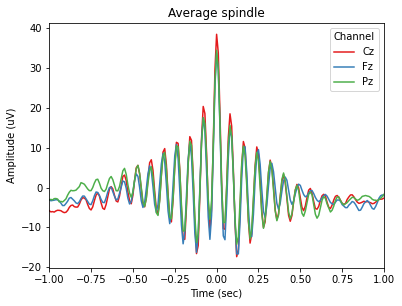

In [6]:
# Plot an average template per channel
sp.plot_average(ci=None, palette="Set1");

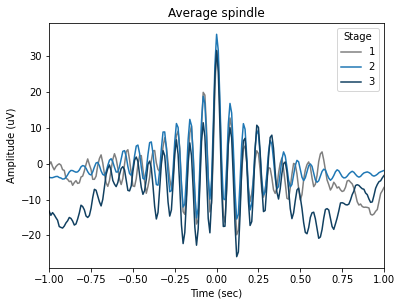

In [7]:
# Plot an average template per stage, using a custom color palette
sp.plot_average(hue="Stage", ci=None, palette=['tab:grey', 'tab:blue', '#114061']);

**Detection on N2 and N3 sleep only (exclude N1)**

In [8]:
sp = yasa.spindles_detect(data, sf, ch_names=ch_names, hypno=hypno, include=(2, 3))

# Now we're only grouping (= stratifying) by stage but not by channel
# We're also using the median instead of the mean to calculate the average spindles features
sp.summary(grp_chan=False, grp_stage=True, aggfunc='median').round(3)

,Count,Density,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Stage,,,,,,,,,,
2,1535,9.654,0.94,71.805,15.671,2.375,0.380,12.549,12.0,0.518
3,69,0.758,0.69,71.868,17.740,2.495,0.314,12.396,8.0,0.500


**Detection on the whole recording**

If we finally decide to apply the detection on the full recording, i.e. not limiting the detection to any sleep stages, we can simply remove the ``hypno=hypno`` argument.

In [9]:
sp = yasa.spindles_detect(data, sf, ch_names=ch_names)

# Here we can only average across channels since sleep stage are unknown.
sp.summary(grp_chan=True).round(3)

,Count,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry
Channel,,,,,,,,,
Cz,671,1.040,78.636,17.154,2.428,0.404,12.655,12.841,0.519
Fz,552,0.986,70.918,15.491,2.328,0.382,12.485,12.022,0.517
Pz,696,1.037,71.008,15.400,2.326,0.396,12.663,12.822,0.512


In [10]:
# Visual inspection of the detected spindles
%matplotlib widget
sp.plot_detection();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/Users/raphael/.pyenv/versions/3.8.3/lib/python3.8/site-packages/traitlets/traitlets.py:567: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(align_items='center', justify_con…